In [259]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

In [260]:
# read all confirmed planets from the exoplanet archive
planets = Table.read('../planets.txt', format='csv')

In [261]:
# habitable zone as a function of teff from https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf

# valid from teff=2600 to 7200 K, T = T* - 5780

# moist greenhouse
coeffs_outer = 1.0146, 8.1884e-5, 1.9394e-9, -4.3618e-12, -6.8260e-16
coeffs_inner = 0.3507, 5.9578e-5, 1.6707e-99, -3.0058e-12, -5.1925e-16

# inner and outer habitable zone insolations 
hz_inner = lambda T: (coeffs_inner[0] 
                      + coeffs_inner[1]*T 
                      + coeffs_inner[2]*(T**2) 
                      + coeffs_inner[3]*(T**3) 
                      + coeffs_inner[4]*(T**4))
hz_outer = lambda T: (coeffs_outer[0] 
                      + coeffs_outer[1]*T 
                      + coeffs_outer[2]*(T**2) 
                      + coeffs_outer[3]*(T**3) 
                      + coeffs_outer[4]*(T**4))

In [439]:
teff_sol = 5777 
lum = (planets['st_rad'] ** 2) * (planets['st_teff']/teff_sol) ** 4
seff = (lum / planets['pl_orbsmax']**2)
in_hz = (seff < hz_outer(planets['st_teff']-5780)) & (seff > hz_inner(planets['st_teff']-5780))
in_hz = in_hz & ~seff.mask

In [440]:
import sys
sys.path.append('../forecaster')
import mr_forecast as mr

In [441]:
minmass_med = np.zeros(len(planets[in_hz]))
minmass_minus = np.zeros(len(planets[in_hz]))
minmass_plus = np.zeros(len(planets[in_hz]))
for i, p in enumerate(planets[in_hz]):
    if (p['pl_radj'] is not np.ma.masked):
        res = mr.Rstat2M(mean=p['pl_radj'], std=p['pl_radjerr1'], unit='Jupiter', sample_size=100, grid_size=100)
        if res is not None:
            m, mminus, mplus = res
            minmass_med[i] = m
            minmass_minus[i] = mminus
            minmass_plus[i] = mplus
        else:
            minmass_med[i] = -1
            minmass_minus[i] = -1
            minmass_plus[i] = -1
    else:
        minmass_med[i] = -1
        minmass_minus[i] = -1
        minmass_plus[i] = -1

In [442]:
hz_planets = planets[in_hz]
hz_planets.add_column(np.ma.masked_where(minmass_med == -1, minmass_med), name='pl_minmass_med')
hz_planets.add_column(np.ma.masked_where(minmass_plus == -1, minmass_plus), name='pl_minmass_plus')
hz_planets.add_column(np.ma.masked_where(minmass_minus == -1, minmass_minus), name='pl_minmass_minus')

In [524]:
mj_ms = 0.0009543
hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
t_hill = lambda mp, ms, a, e, P: hill(mp, ms, a, e) * P / (2 * np.pi * a)

In [666]:
th = np.zeros(len(hz_planets))
rh = np.zeros(len(hz_planets))
for i, p in enumerate(hz_planets):
    if p['pl_radj'] is not np.ma.masked:
        th[i] = 24*t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], p['pl_orbeccen'], p['pl_orbper'])
        rh[i] = hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], p['pl_orbeccen']) / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
    else:
        th[i] = 24*t_hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], p['pl_orbeccen'], p['pl_orbper'])
        rh[i] = hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], p['pl_orbeccen']) / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Warning: converting a masked element to nan.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Warning: converting a masked element to nan.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Warning: converting a masked element to nan.
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


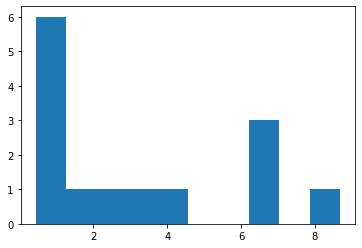

In [667]:
pl.hist(th[th < 10]);

In [675]:
c = (th / 3 * 5) < 100
for i, p in enumerate(hz_planets[c]):
    print(p['pl_name'], "\t", th[c][i] / 3 * 5, "\t", p['st_teff'], "\t", rh[c][i])

GJ 1148 b 	 10.640720507282296 	 3264.0 	 0.04039247145309366
Kepler-186 f 	 11.416159685090719 	 3755.0 	 0.013800135365472142
HIP 79431 b 	 58.934490856609685 	 3368.0 	 0.08287742324000888
55 Cnc f 	 42.50238967235041 	 5196.0 	 0.025481907472264646
HD 10180 g 	 79.45520050246563 	 5911.0 	 0.02064066963699622
HD 137388 b 	 61.038280056410805 	 5181.0 	 0.029054153365602516
Kepler-16 b 	 69.78235528190842 	 4450.0 	 0.04791318466618797
HD 20782 b 	 14.48036070625222 	 5790.0 	 0.0038095892532925084
HD 20868 b 	 61.006643026339276 	 4802.0 	 0.02516187692258725
HD 28254 b 	 94.9590839048341 	 5664.0 	 0.013365715071104105
BD-08 2823 c 	 72.81945871200841 	 4816.0 	 0.04814164068350819
HD 43197 b 	 20.7055079468107 	 5508.0 	 0.009921945035775714
HD 218566 b 	 43.9983523052375 	 4730.0 	 0.030621378017764662
Kepler-453 b 	 46.84739058438634 	 5527.0 	 0.030597418348161928
Kepler-296 f 	 5.266952811656745 	 3740.0 	 0.01306251556959775
TRAPPIST-1 e 	 0.7302165838232523 	 2559.0 	 0.018

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


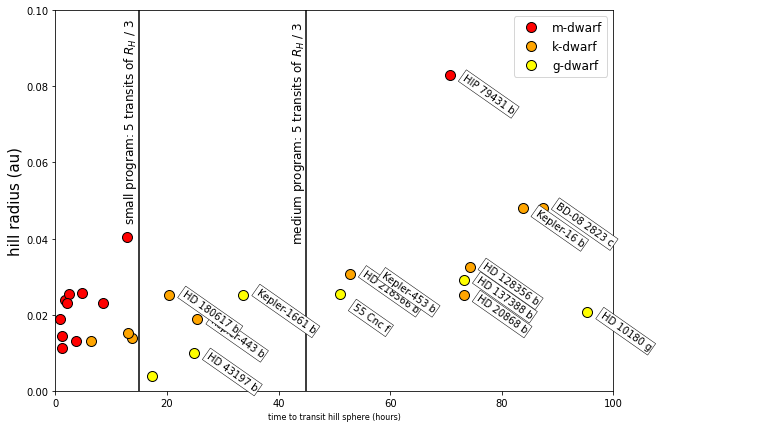

In [686]:
pl.figure(figsize=(10, 7))
mdwarf = hz_planets['st_teff'] < 3500
kdwarf = (hz_planets['st_teff'] > 3500) & (hz_planets['st_teff'] < 5000)
gdwarf = (hz_planets['st_teff'] > 5000) & (hz_planets['st_teff'] < 6000)
pl.plot(2*th[mdwarf], rh[mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[kdwarf], rh[kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[gdwarf], rh[gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 100)
pl.ylim(0, 0.1)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    if 2*t > 15:
        pl.annotate(pname, xy=(2*t+2, r - 0.01), rotation=-35, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')
pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
            xy=(25 * 3 / 5 - 3, 0.045), rotation=90, fontsize=12)
pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
            xy=(75 * 3 / 5 - 3, 0.04), rotation=90, fontsize=12)

pl.xlabel('time to transit hill sphere (hours)', fontsize=8)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


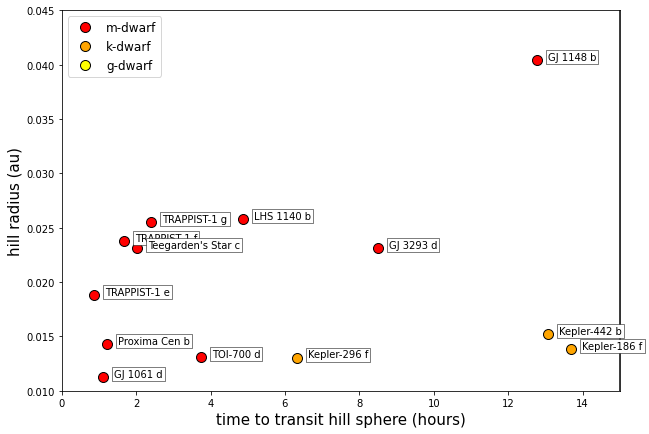

In [673]:
c = th < 7.5

pl.figure(figsize=(10, 7))
mdwarf = hz_planets['st_teff'] < 3500
kdwarf = (hz_planets['st_teff'] > 3500) & (hz_planets['st_teff'] < 5000)
gdwarf = (hz_planets['st_teff'] > 5000) & (hz_planets['st_teff'] < 6000)
pl.plot(2*th[mdwarf], rh[mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[kdwarf], rh[kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[gdwarf], rh[gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 15)
pl.ylim(0.01, 0.045)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    pl.annotate(pname, xy=(2*t+0.3, r), rotation=0, 
                bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12)